Import Bibliotek, danych użytych w zadaniu i podstawowy setup

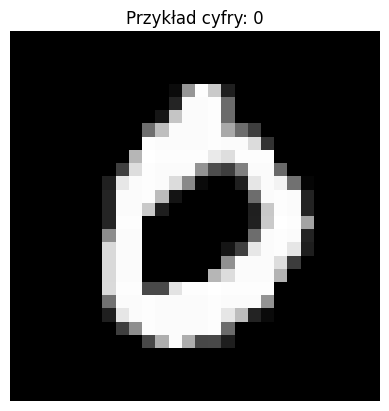

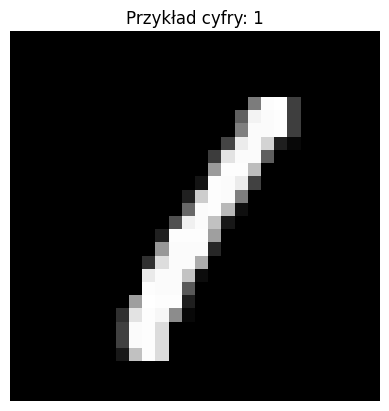

Treningowe dane info: (60000, 28, 28)
Testowe dane info: (10000, 28, 28)


In [43]:
import tensorflow as tf
import torch
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, precision_score,recall_score,roc_auc_score

SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_test[3], cmap='gray')
plt.title(f"Przykład cyfry: {y_test[3]}")
plt.axis('off')
plt.show()

plt.imshow(x_train[3], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[3]}")
plt.axis('off')
plt.show()

print(f"Treningowe dane info: {x_train.shape}")
print(f"Testowe dane info: {x_test.shape}")


**Obserwacje**

Podobnie jak w przypadku zadania 1 trzeba zauważyć jakie cechy odróżniaja różne wyniki. W przypadku liczb przede wszystkim ważne są krawędzie.

**Metryki**

Najważniejszą metryką w klasyfikacji cyfr będzie oczywiście accuracy. Chociaż metryki takie jak Precision, Recall oraz wynik F1 też mogą pokazać pewne problemy w działaniu naszej sieci więc też zostaną sprawdzone. Dodatkowo Confusion Matrix jest w stanie nam łatwo pokazać, gdy jakaś z cyfr jest szczególnie trudna do wychwycenia przez sieć.

Tutaj stworzę parę przydatnych funkcji do testowania różnych sieci w zależności od ich budowy oraz innych parametrów.

In [44]:
def test_nn(model_nn,number_epochs,learning_rt,optimizer="adam",criterion = nn.CrossEntropyLoss(),batch_size=100,plot=True):
  # Ustalanie urządzenia
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model_nn.to(device)

  # Wybieranie optimizera

  if optimizer == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rt)
  elif optimizer == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rt)
  else:
    print("Niepoprawny optimizer")
    return

  # Przygotowanie danych i dataloaders

  x_train_t = torch.tensor(x_train, dtype=torch.float32) / 255.0
  x_test_t  = torch.tensor(x_test, dtype=torch.float32) / 255.0
  y_train_t = torch.tensor(y_train, dtype=torch.long)
  y_test_t  = torch.tensor(y_test, dtype=torch.long)

  # Normalizacja (średnia/odchylenie MNIST)
  mean, std = 0.1307, 0.3081
  x_train_t = (x_train_t - mean) / std
  x_test_t  = (x_test_t - mean) / std

  # Sprawdzam czy pierwsza warstwa jest warstwą CNN

  if any(isinstance(m, nn.Conv2d) for m in model.modules()):
        x_train_t = x_train_t.unsqueeze(1)
        x_test_t  = x_test_t.unsqueeze(1)

  train_data = TensorDataset(x_train_t, y_train_t)
  test_data  = TensorDataset(x_test_t, y_test_t)

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  # Trenowanie
  eval_his = {
      "train_loss": [],
      "test_loss": [],
      "train_acc": [],
      "test_acc": [],
      "precision": [],
      "recall":[],
      }
  for epoch in range(number_epochs):
    model.train()
    running_loss, correct, total = 0,0,0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total


    # Ewaluacja
    model.eval()
    test_running_loss, test_correct, test_total = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss = test_running_loss / len(test_loader)
    test_acc = 100 * test_correct / test_total
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    # Wypisywanie wyniku danej iteracji
    print(f"Epoch [{epoch+1}/{number_epochs}] "
              f"Train Loss: {running_loss/len(train_loader)} "
              f"Train Acc: {train_acc}%\n"
              f"Test Loss: {test_loss} "
              f"Test Acc: {test_acc}%"
              )

    #Zapisywanie danych
    eval_his["train_loss"].append(train_loss)
    eval_his["train_acc"].append(train_acc)
    eval_his["test_loss"].append(test_loss)
    eval_his["test_acc"].append(test_acc)
    eval_his["precision"].append(precision)
    eval_his["recall"].append(recall)
    #eval_his["roc_auc"].append(roc_auc)

    data = pd.DataFrame(eval_his)

  if plot:
    plt_res(model,data)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    confusion_plot(conf_matrix)

  return model,data

# Funcja do grafowania metryk mierzonych przez funkcje testową
def plt_res(model,data):
  '''
  Funkcja przyjmuje dane data w formacie data={
      "train_loss": [],
      "test_loss": [],
      "train_acc": [],
      "test_acc": [],
      "precision": [],
      "recall":[],
  '''
  epochs = range(1, len(data["train_loss"]) + 1)



  plt.figure(figsize=(12,5))

     # Accuracy plot
  plt.subplot(1,2,1)
  plt.plot(epochs, data["train_acc"], "o-", label="Train Acc")
  plt.plot(epochs, data["test_acc"], "o-", label="Test Acc")
  plt.grid()
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy over Epochs")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()

    # Loss plot
  plt.subplot(1,2,2)
  plt.plot(epochs, data["train_loss"], "o-", label="Train Loss")
  plt.plot(epochs, data["test_loss"], "o-", label="Test Loss")
  plt.grid()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss over Epochs")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()

  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(epochs, data["precision"], "o-", label="Test Precision")
  plt.grid()
  plt.xlabel("Epoch")
  plt.ylabel("Precision")
  plt.title("Precision over Epochs")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, data["recall"], "o-", label="Test Recall")
  plt.grid()
  plt.xlabel("Epoch")
  plt.ylabel("Recall")
  plt.title("Recall over Epochs")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()

  plt.tight_layout()
  plt.show()

# Confusion Matrix jako heatmapa
def confusion_plot(conf_matrix):
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()



**Tworzenie Baseline modelu**

Accuracy for baseline: 0.8797



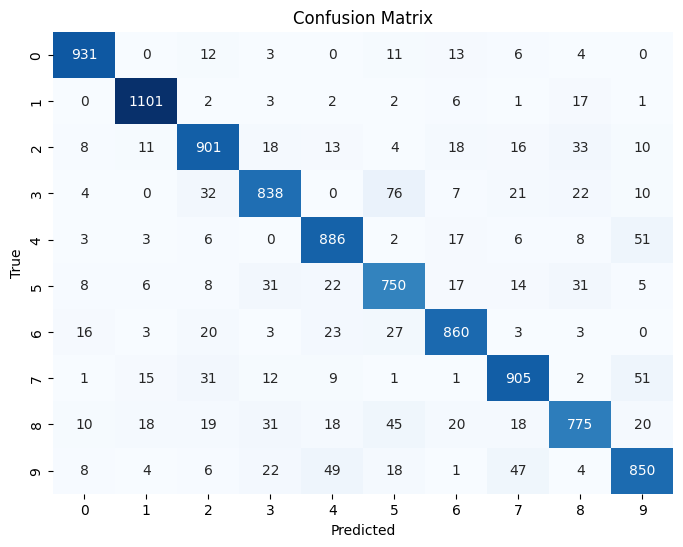

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.87      0.87      0.87      1032
           3       0.87      0.83      0.85      1010
           4       0.87      0.90      0.88       982
           5       0.80      0.84      0.82       892
           6       0.90      0.90      0.90       958
           7       0.87      0.88      0.88      1028
           8       0.86      0.80      0.83       974
           9       0.85      0.84      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [45]:
x_train_flat = x_train.reshape(x_train.shape[0], -1) /255.0
x_test_flat = x_test.reshape(x_test.shape[0], -1) /255.0

clf = LogisticRegression().fit(x_train_flat[:2200], y_train[:2200])
y_pred = clf.predict(x_test_flat)

print(f'Accuracy for baseline: {accuracy_score(y_test, y_pred)}\n')
confusion_plot(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Baseline osiągnął accuracy na poziomie około 0.88. Przy nauce modelu działałem jedynie na części danych (Tak jak w poleceniu).

Najpierw stworzę prostą sieć liniową

Epoch [1/15] Train Loss: 0.3871498108903567 Train Acc: 89.06666666666666%
Test Loss: 0.2197610443457961 Test Acc: 93.32%
Epoch [2/15] Train Loss: 0.1959219041032096 Train Acc: 94.31166666666667%
Test Loss: 0.18110566559247673 Test Acc: 94.57%
Epoch [3/15] Train Loss: 0.15087305124228198 Train Acc: 95.69166666666666%
Test Loss: 0.14447012399323284 Test Acc: 95.59%
Epoch [4/15] Train Loss: 0.12630167215752106 Train Acc: 96.32833333333333%
Test Loss: 0.1268741140468046 Test Acc: 95.93%
Epoch [5/15] Train Loss: 0.10892297808701794 Train Acc: 96.78666666666666%
Test Loss: 0.12155536267440765 Test Acc: 96.32%
Epoch [6/15] Train Loss: 0.09790319109025102 Train Acc: 97.09333333333333%
Test Loss: 0.11177867422113195 Test Acc: 96.45%
Epoch [7/15] Train Loss: 0.08853092442887525 Train Acc: 97.36333333333333%
Test Loss: 0.11615865717758425 Test Acc: 96.51%
Epoch [8/15] Train Loss: 0.08061152664013208 Train Acc: 97.535%
Test Loss: 0.10811794108245522 Test Acc: 96.73%
Epoch [9/15] Train Loss: 0.0744

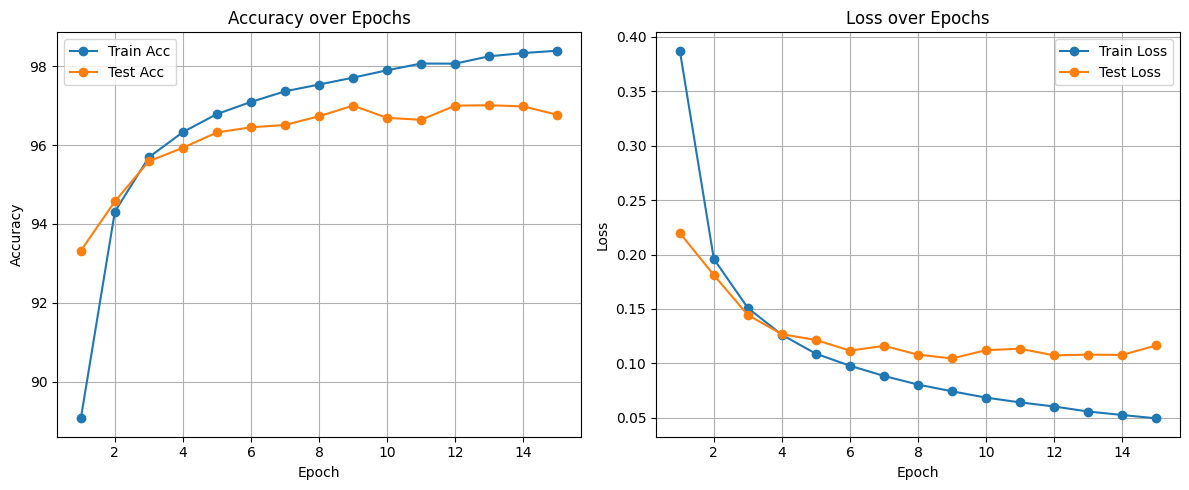

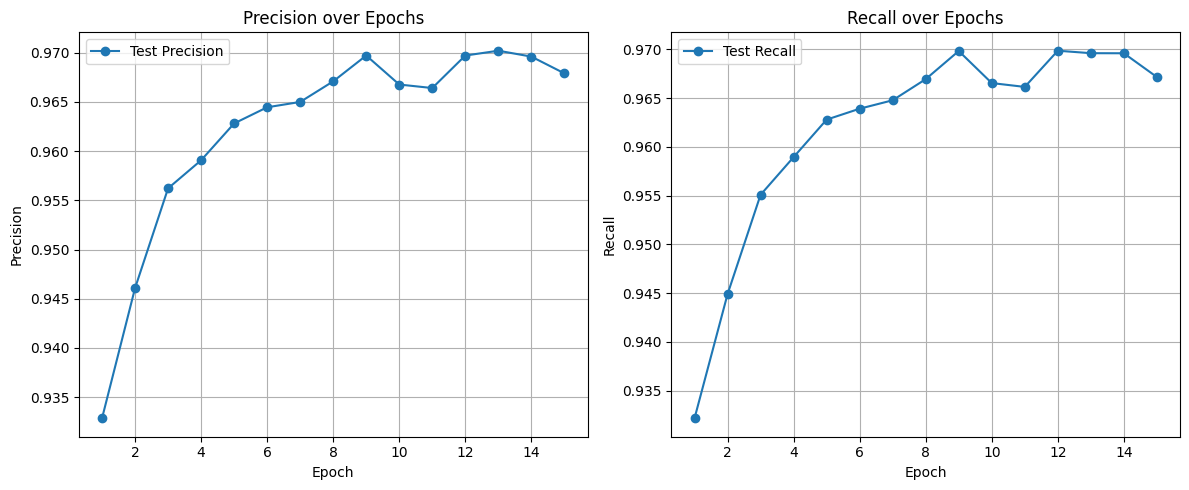

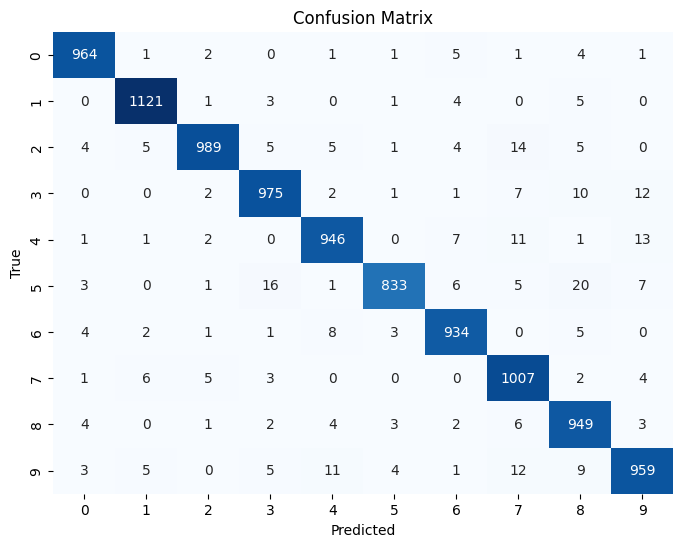

In [46]:
class MLP(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = nn.Linear(28*28,32)
    self.fc2 = nn.Linear(32,10)
    self.relu = nn.ReLU()
  def forward(self,x):
    x = x.view(-1,28*28)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

# Ustalenie parametrów
params = {
    "number_epochs": 15,
    "batch_size":100,
    "learning_rt": 0.001,
    "optimizer": "adam",
}
model_MLP,data = test_nn(MLP(),**params)

Przetestowany model był w stanie osiągnąć accuracy lekko poniżej 0,97, co jest zadowalającym wynikiem, który jednak można jeszcze poprawić. Na powyższej heatmapie możemy zauważyć, jakie liczby były mylone. Są to między innymi 4–7, 5–8, 7–2 i 7–9. Liczby te są dość podobne, więc nie dziwi, że sieć czasami je myli. Jednocześnie dalsza nauka nie pomoże w tej sytuacji, ponieważ trend wzrostu accuracy zaczął przypominać funkcję logarytmiczną.

Dodatkowe, bardziej luźne wnioski. Oczywista oczywistość, ale struktura sieci ma spory wpływ na to, jak efektywna jest nasza sieć. Przykładowo wcześniej próbowałem na sieciach liniowych zrobić model, który uczyłby się jak najmniej, i zamiana 28*28 – 1 – 10 okazała się całkiem koszmarną architekturą. Jako że powyższa sieć pozostaje tak naprawdę konceptem eksplorowanym głównie w celu porównania do CNN, osiągnięty wynik wydawał mi się wystarczający.

**Model konwolucyjny**

W celu osiągnięcia lepszego wyniku stworzę model z warstwami konwolucyjnymi które pozwolą sieci na rozpoznawanie krawędzi oraz zakrzywień.

Epoch [1/6] Train Loss: 0.20034564567654373 Train Acc: 94.13666666666667%
Test Loss: 0.05243986639055901 Test Acc: 98.28%
Epoch [2/6] Train Loss: 0.09011961406182203 Train Acc: 97.33333333333333%
Test Loss: 0.038984291558712365 Test Acc: 98.84%
Epoch [3/6] Train Loss: 0.06985363621611708 Train Acc: 97.84%
Test Loss: 0.03745322632184864 Test Acc: 98.75%
Epoch [4/6] Train Loss: 0.05736847962577964 Train Acc: 98.27833333333334%
Test Loss: 0.033761778956721604 Test Acc: 98.96%
Epoch [5/6] Train Loss: 0.047026567106722976 Train Acc: 98.565%
Test Loss: 0.027088528124077447 Test Acc: 99.19%
Epoch [6/6] Train Loss: 0.041781812244075546 Train Acc: 98.76666666666667%
Test Loss: 0.025603949758611622 Test Acc: 99.2%


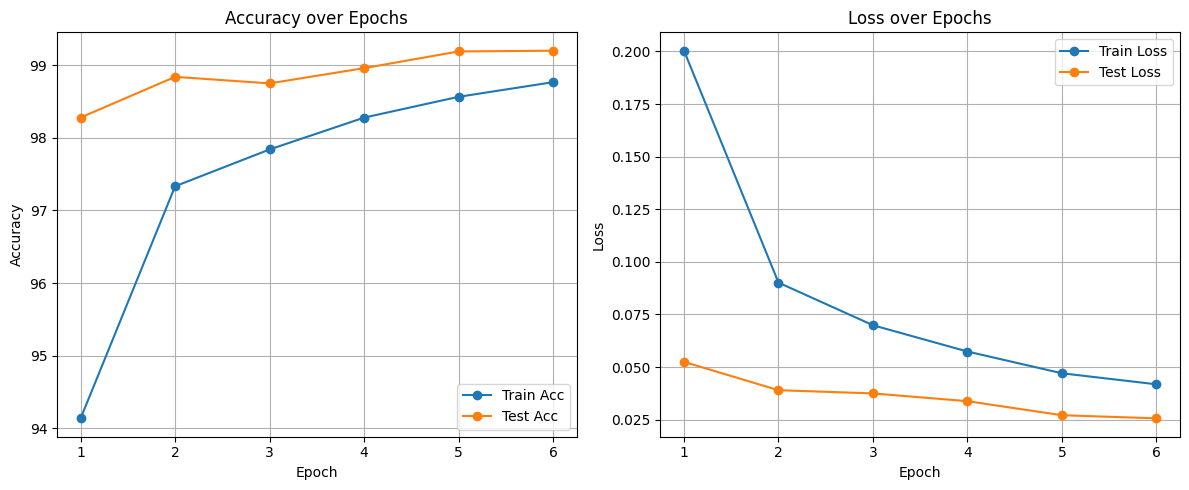

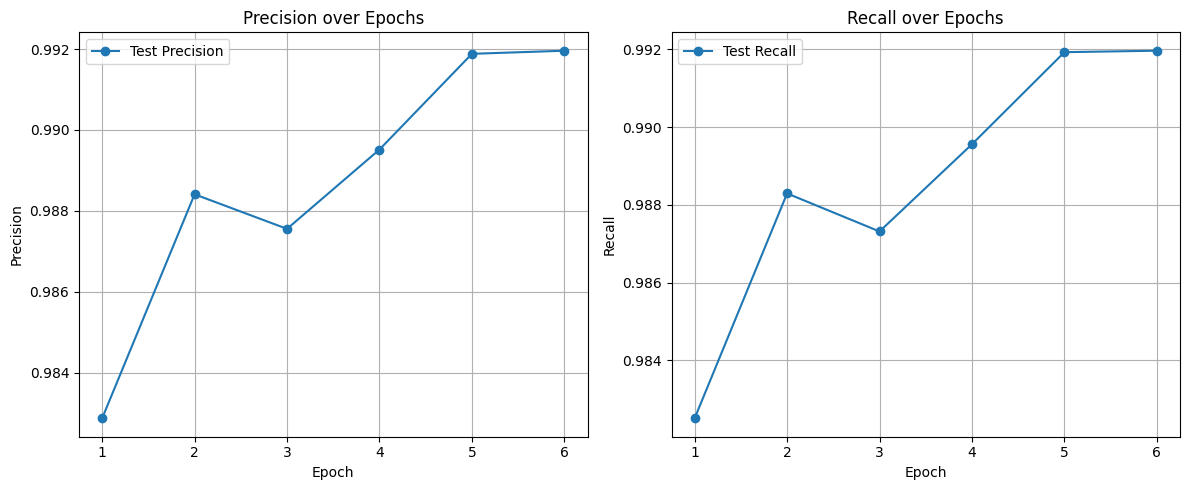

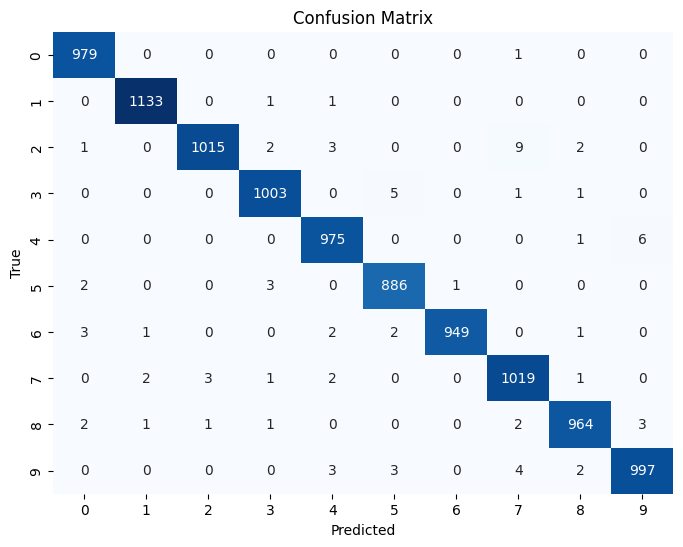

In [47]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2,2)
        self.drop = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128*7*7,128)
        self.fc2 = nn.Linear(128,10)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.pool(self.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(self.relu(self.batch_norm2(self.conv2(x))))
        x = self.drop(x)
        x = x.view(x.size(0),-1)
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x
# Ponowne ustalenie parametrów
params = {
    "number_epochs": 6,
    "batch_size":64,
    "learning_rt": 0.002,
    "optimizer": "adam",
}
model_CNN,data = test_nn(CNN(),**params)

Końcowy wynik accuracy dla sieci konwolucyjnej to 0,992. Jest to zadowalający rezultat, przewyższający zarówno baseline używający regresji logistycznej, jak i prostszą sieć liniową. Wyniki recall oraz precision również pokazują, że sieć konwolucyjna jest lepiej przystosowana do rozróżniania liczb niż pozostałe metody. Wynik ten został poprawiony między innymi dzięki dodaniu BatchNorm oraz zwiększeniu wysokości w warstwach. Przedstawione wykresy pokazują, że po 6 iteracjach model poprawia się już w niewielkim stopniu.

**Podsumowanie**

Udało się wytrenować parę modeli klasyfikujących obrazy w danym formacie jako liczby. Najbardziej efektywnym jest CNN, który dzięki konwolucji jest w stanie rozpoznać krawędzie będące jedną z definijących cech każdej liczby.

Ps. nie popełniajcie mojego błedu róbcie to wszystko na karcie graficznej